# Pakage

In [1]:
from pandana.loaders import osm
import geopandas as gpd
import pydeck as pdk
import ee
import multiprocessing
from functools import partial
import pandas as pd
import contextily as ctx
from mapbox import Directions
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import googlemaps
import plotly.express as px
import h3
from googlemaps import Client as GoogleMaps
from datetime import datetime
import cartopy.crs as ccrs
import seaborn as sns
import cartopy.feature as cfeature
from tobler.util import h3fy
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
import multiprocessing
from tobler.area_weighted import area_interpolate
import plotly.io as pio
import transbigdata as tbd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import requests
import dask
import datashader as ds
import datashader.transfer_functions as tf
from shapely.geometry import LineString, MultiLineString, Point
import plotly.express as px
import io
import zipfile
import warnings
import numpy as np
import matplotlib.cm as cm
import folium
from matplotlib.colors import LogNorm
import networkx as nx
import osmnx as ox
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from shapely import wkt
import pandana
import contextily as cx
import matplotlib.patches as mpatches
from shapely.ops import cascaded_union
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load datasets
NYC_Green_Space_HEX = pd.read_csv('NYC_Green_Space_HEX.csv')
NYC_EV_STATION_HEX = pd.read_csv('NYC_EV_STATION_HEX.csv')
NYC_EV_CO2_HEX = pd.read_csv('NYC_EV_CO2_HEX.csv')
NYC_LST_HEX = pd.read_csv('NYC_LST_HEX.csv')
NYC_EV_Demand_HEX = pd.read_csv('NYC_EV_Demand_HEX.csv')
mean_centrality_per_hex = pd.read_csv('mean_centrality_per_hex.csv')
mean_degree_per_hex = pd.read_csv('mean_degree_per_hex.csv')
hexagons_street_density = pd.read_csv('hexagons_street_density.csv')

# Drop unnecessary first columns if they are indexes from all CSV files
csv_files = [NYC_Green_Space_HEX, NYC_EV_STATION_HEX, NYC_EV_CO2_HEX, NYC_EV_Demand_HEX, mean_centrality_per_hex, mean_degree_per_hex, hexagons_street_density, NYC_LST_HEX]
for file in csv_files:
    if 'Unnamed: 0' in file.columns:
        file.drop('Unnamed: 0', axis=1, inplace=True)

# Merge DataFrames on 'hex_id' using inner joins
HEXS = pd.merge(NYC_Green_Space_HEX.drop(columns=['geometry']), NYC_EV_STATION_HEX.drop(columns=['geometry']), on='hex_id', how='inner')
HEXS = pd.merge(HEXS, NYC_EV_CO2_HEX.drop(columns=['geometry']), on='hex_id', how='inner')
HEXS = pd.merge(HEXS, NYC_EV_Demand_HEX.drop(columns=['geometry']), on='hex_id', how='inner')
HEXS = pd.merge(HEXS, mean_centrality_per_hex, on='hex_id', how='inner')
HEXS = pd.merge(HEXS, mean_degree_per_hex, on='hex_id', how='inner')
HEXS = pd.merge(HEXS, hexagons_street_density, on='hex_id', how='inner')
HEXS = pd.merge(HEXS, NYC_LST_HEX, on='hex_id', how='inner')  # Including geometry from the last DataFrame

# Drop unnecessary columns
HEXS = HEXS.drop(columns=['centroid', 'EV_Station_Density'])
# Convert 'has_green_space' to integer if necessary
HEXS['has_green_space'] = HEXS['has_green_space'].astype(int)
HEXS.rename(columns={'count': 'EV_DEMAND_COUNT'}, inplace=True)
HEXS.head()

,hex_id,has_green_space,EV_Station_Count,area_km2,emissions_per_hex,EV_DEMAND_COUNT,mean_centrality,Mean_Degree,street_density_km,geometry,lst_value
0,882a106e0dfffff,1,0.0,0.548716,5059.507584,5.0,0.009831,5.204545,2.156995e+09,"POLYGON ((564391.4063561409 4483712.571295817,...",0.000000
1,882a106e63fffff,1,0.0,0.738377,15457.885399,17.0,0.009838,5.750000,2.356213e+09,POLYGON ((564550.8106774171 4484208.0038944995...,20.925329
2,882a106e67fffff,1,0.0,0.324066,2462.177860,0.0,0.009593,5.214286,2.325496e+09,"POLYGON ((563637.5785253054 4484457.738802825,...",22.617778
3,882a106e47fffff,1,0.0,0.738411,6870.573109,0.0,0.010138,4.466667,1.058723e+09,"POLYGON ((566159.770793673 4484576.584834952, ...",20.245281
4,882a106e6bfffff,1,0.0,0.738450,15987.604986,38.0,0.010616,4.666667,2.343848e+09,POLYGON ((565246.5539134067 4484826.3294211915...,20.925329


In [11]:
# Check for NaN values
nan_columns = HEXS.isna().any()
nan_columns_list = nan_columns[nan_columns].index.tolist()
if nan_columns_list:
    print("NaN values found in the following columns:", nan_columns_list)
else:
    print("No NaN values found.")

NaN values found in the following columns: ['mean_centrality', 'Mean_Degree']


In [20]:
from sklearn.impute import SimpleImputer

# Imputer for filling missing values with the mean
imputer = SimpleImputer(strategy='mean')

HEXS['mean_centrality'] = imputer.fit_transform(HEXS[['mean_centrality']])
HEXS['Mean_Degree'] = imputer.fit_transform(HEXS[['Mean_Degree']])

# Check again for NaN values
nan_columns_after = HEXS.isna().any()
nan_columns_list_after = nan_columns_after[nan_columns_after].index.tolist()
if nan_columns_list_after:
    print("NaN values are still found in the following columns:", nan_columns_list_after)
else:
    print("No NaN values remain.")

No NaN values remain.


In [32]:
# HEXS.to_csv('NYC_HEX_Var.csv', index=False)

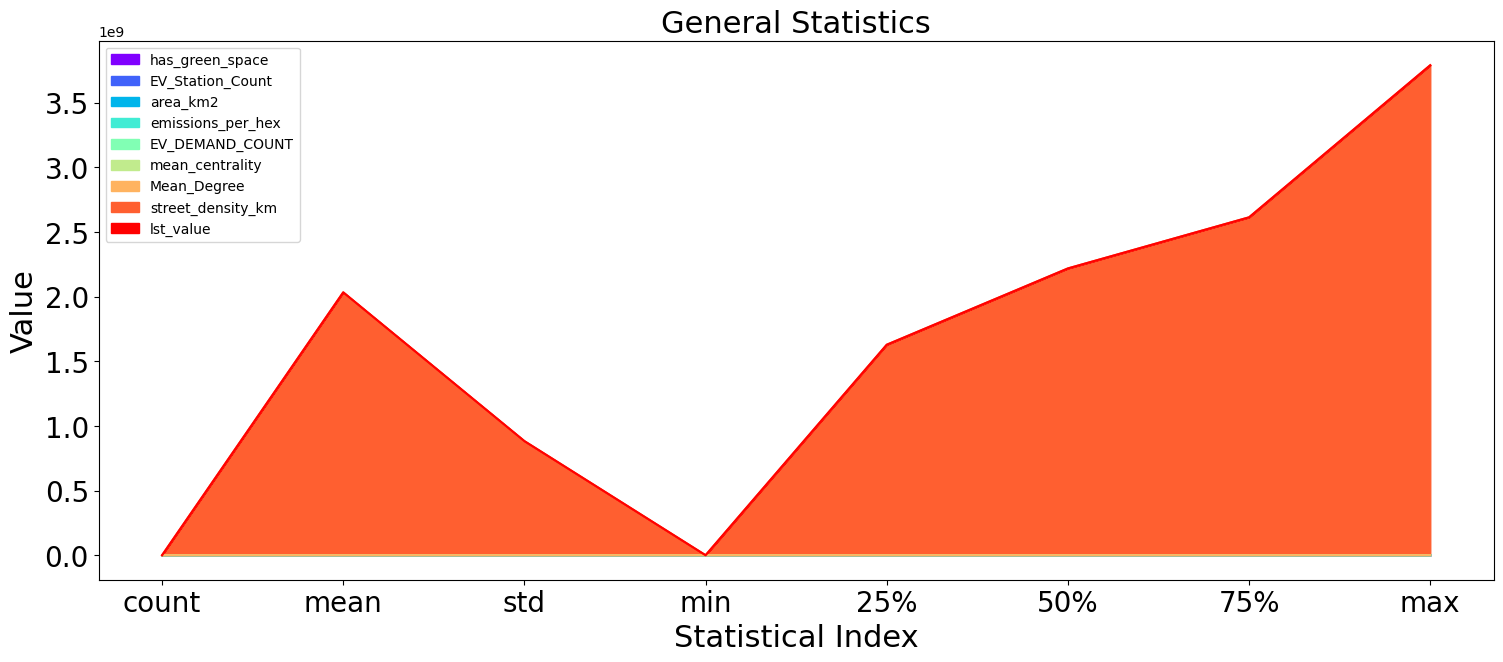

,has_green_space,EV_Station_Count,area_km2,emissions_per_hex,EV_DEMAND_COUNT,mean_centrality,Mean_Degree,street_density_km,lst_value
count,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1.045000e+03,1045.000000
mean,0.405742,0.594258,0.699686,27749.255364,26.897608,0.014727,4.971873,2.033708e+09,19.138678
std,0.491270,1.947581,0.095709,29120.500697,25.618556,0.002130,0.839231,8.828010e+08,6.697983
min,0.000000,0.000000,0.164742,0.000000,0.000000,0.005064,2.000000,0.000000e+00,0.000000
25%,0.000000,0.000000,0.732295,7997.044293,8.000000,0.013671,4.479452,1.628546e+09,19.880791
50%,0.000000,0.000000,0.740145,17661.507637,21.000000,0.014856,4.971873,2.218814e+09,21.178608
75%,1.000000,0.000000,0.741304,36960.783804,37.000000,0.016167,5.500000,2.614260e+09,22.254615
max,1.000000,21.000000,0.743823,163168.749871,200.000000,0.019707,7.577778,3.790589e+09,25.604519


In [14]:
HEXS.describe().plot(kind="area", fontsize=20, figsize=(18,7), table=False, colormap="rainbow")
plt.xlabel('Statistical Index', fontsize = 22)
plt.ylabel('Value', fontsize = 22)
plt.title("General Statistics", fontsize = 22)
plt.show()
HEXS.describe()

In [15]:
# Exclude non-numeric columns and then calculate skewness
numeric_cols = HEXS.select_dtypes(include=['number'])  # Select only numeric columns
skewness = numeric_cols.skew()  # Calculate skewness 偏态 
skewness

has_green_space      0.384469
EV_Station_Count     5.095616
area_km2            -2.739518
emissions_per_hex    1.877040
EV_DEMAND_COUNT      1.602518
mean_centrality     -0.720020
Mean_Degree         -0.282034
street_density_km   -0.725095
lst_value           -2.334364
dtype: float64

In [16]:
numeric_cols.kurt() # 峰态

has_green_space      -1.855739
EV_Station_Count     32.485863
area_km2              7.419269
emissions_per_hex     3.691306
EV_DEMAND_COUNT       3.794931
mean_centrality       0.909875
Mean_Degree           1.287005
street_density_km    -0.083623
lst_value             3.980475
dtype: float64

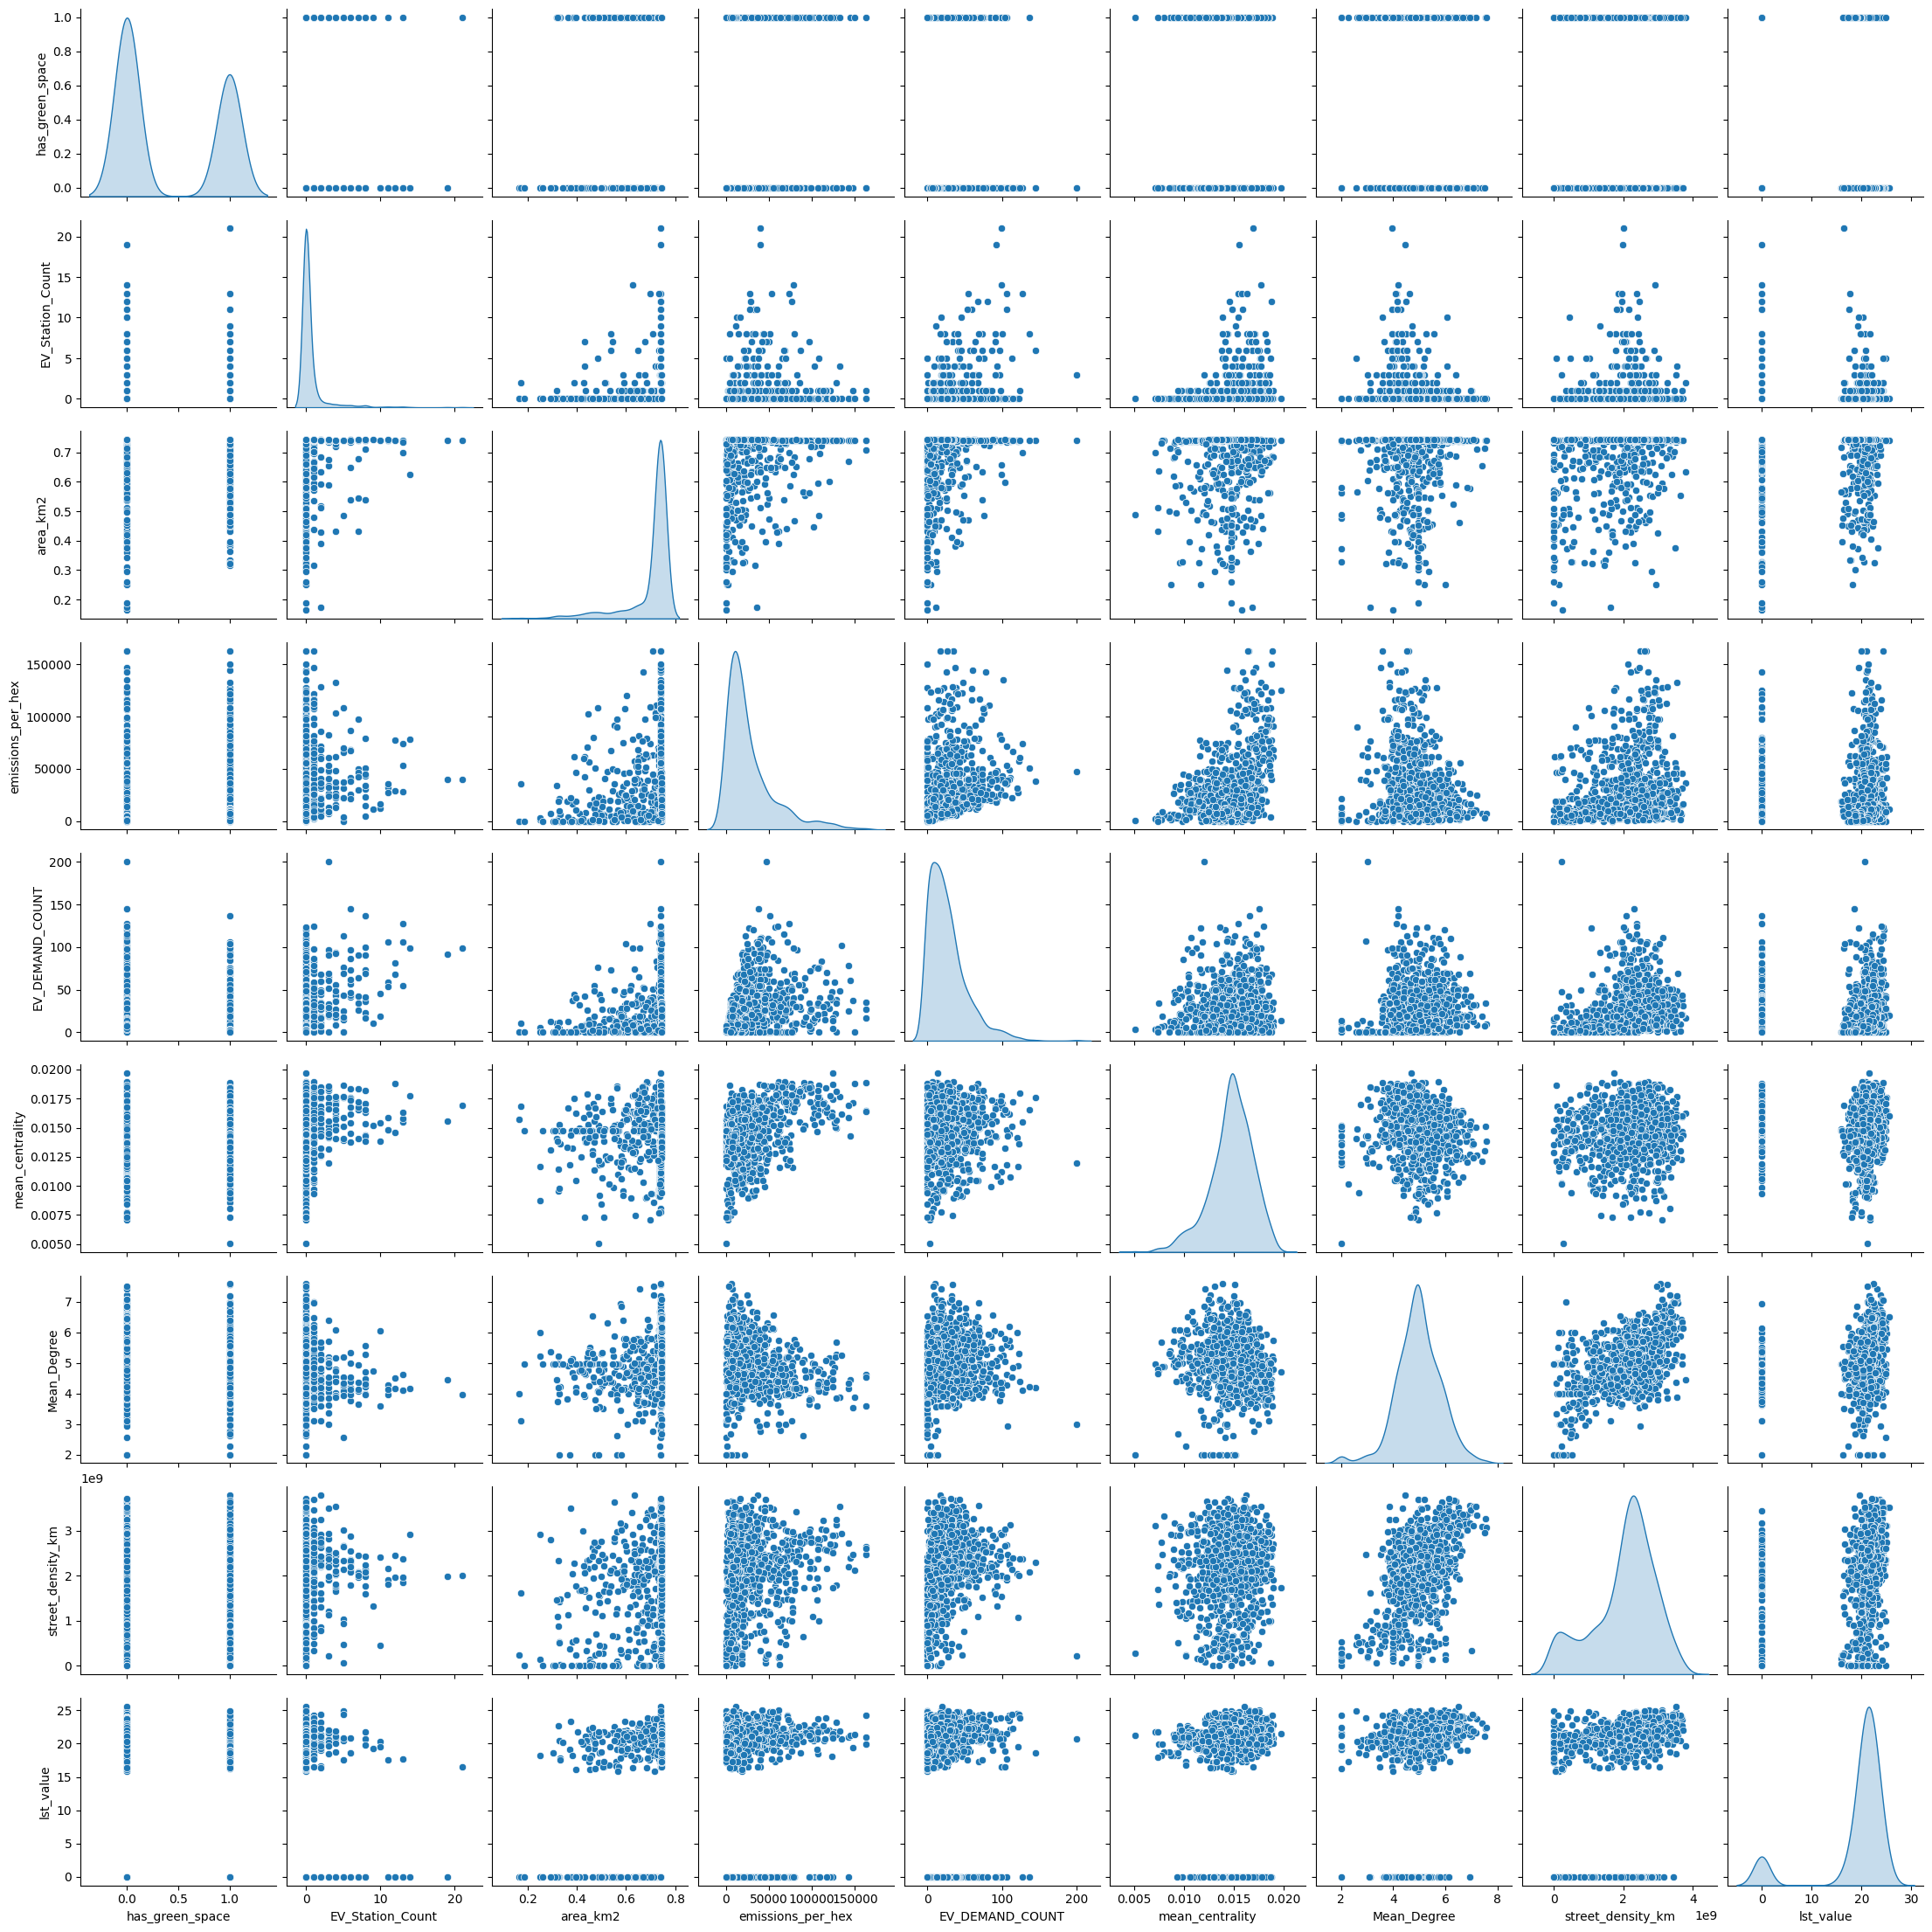

In [17]:
sns.pairplot(HEXS, diag_kind='kde')
plt.show()

- Predict Land Surface Temperature (LST) using a regression model.
- Classify Hexes with Green Spaces using a classification model.
- Cluster Hex Tiles Based on Features using a clustering algorithm.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.cluster import KMeans

<Figure size 1000x800 with 0 Axes>

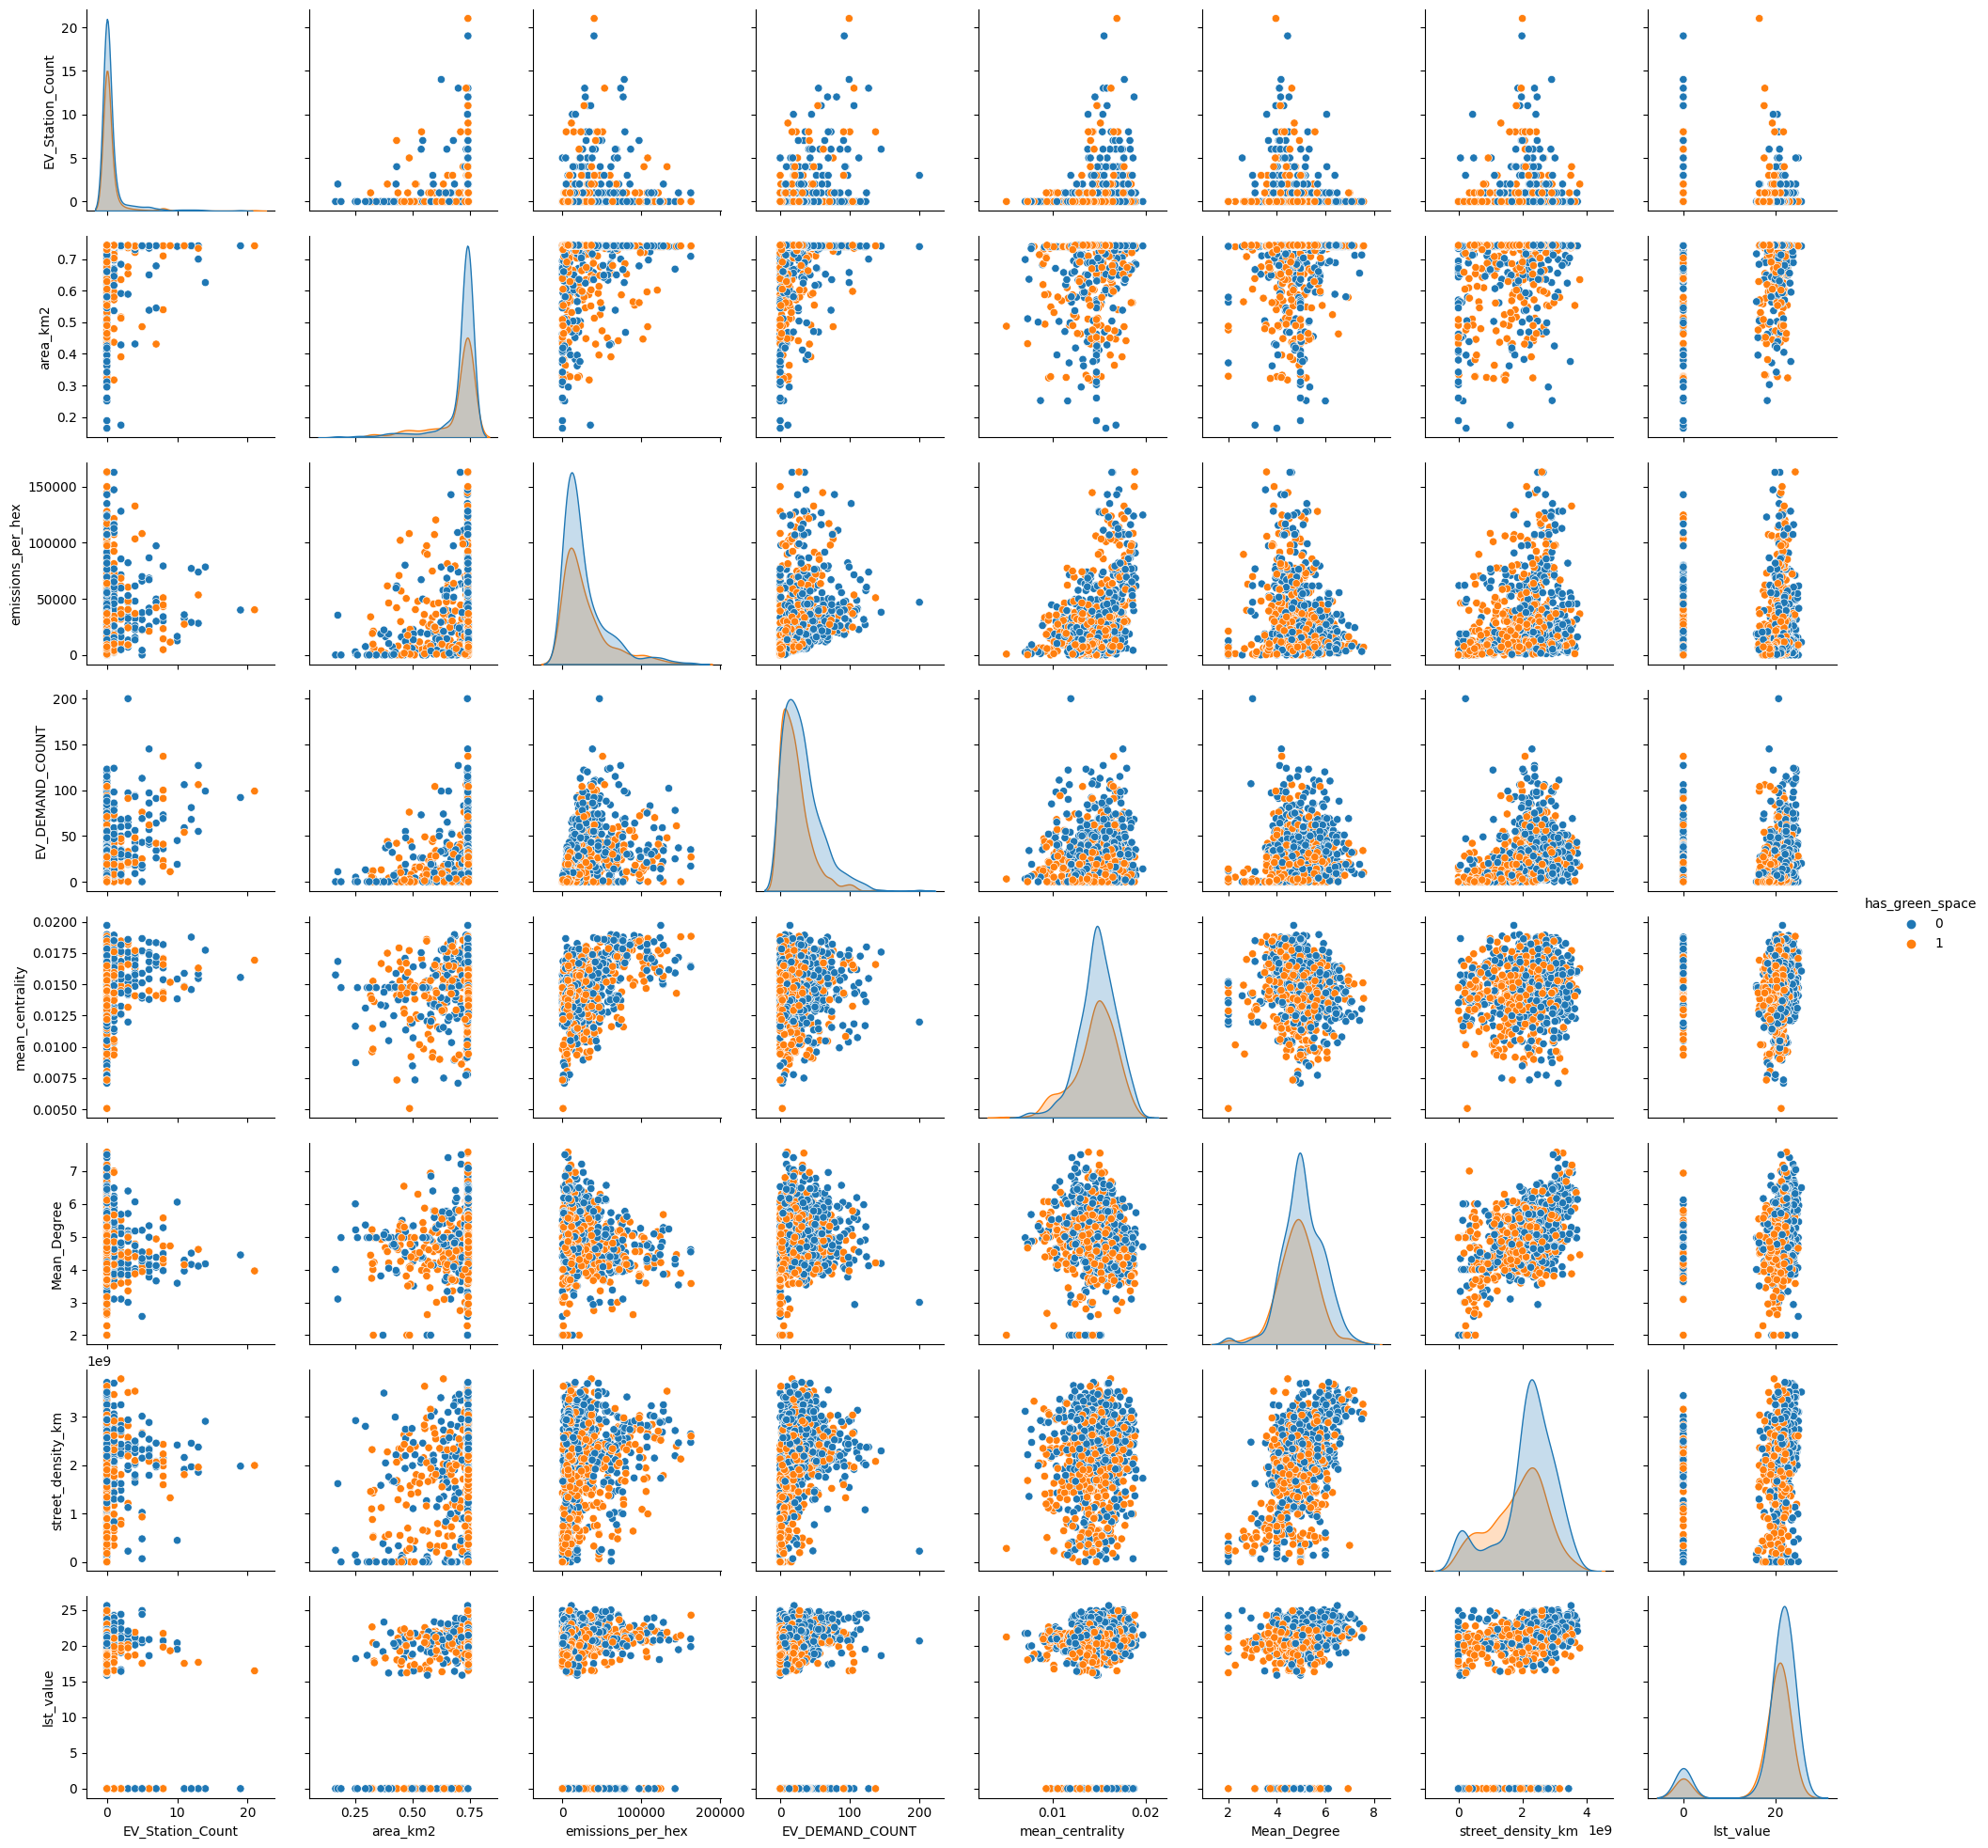

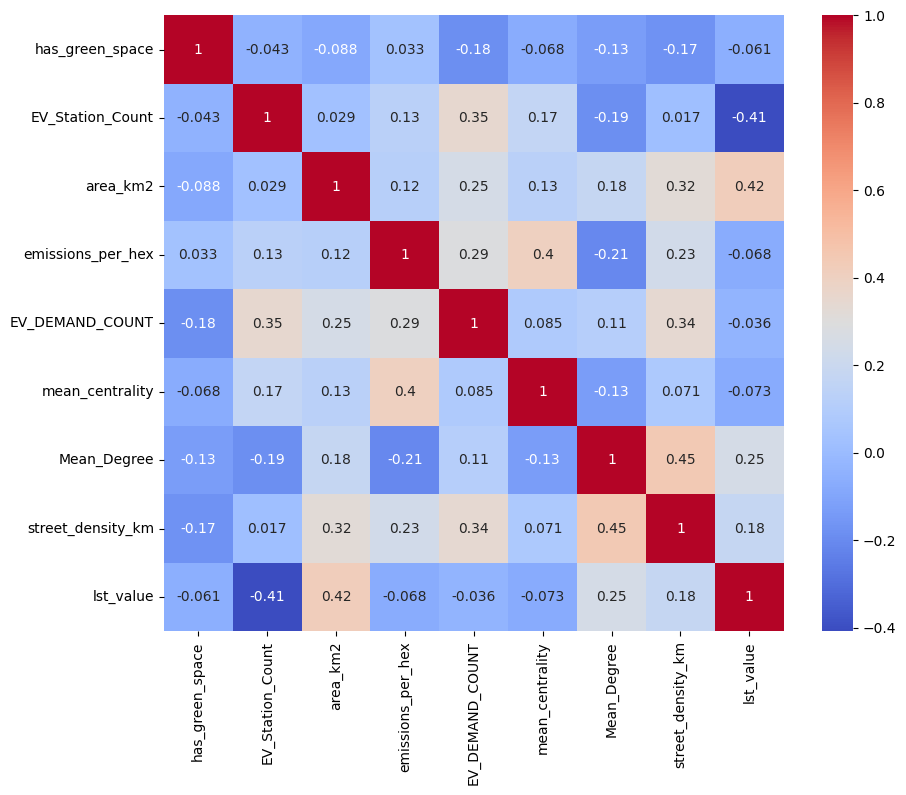

In [22]:
data = HEXS.drop(columns=['hex_id', 'geometry'], inplace=False)
sns.pairplot(data, hue='has_green_space')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [21]:
# Split data for regression (predicting lst_value)
X_reg = data.drop('lst_value', axis=1)
y_reg = data['lst_value']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Fit regression model
reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)
y_pred_reg = reg_model.predict(X_test_reg)
reg_mse = mean_squared_error(y_test_reg, y_pred_reg)
print("Regression MSE:", reg_mse)

Regression MSE: 29.324084315728626


In [23]:
# Split data for classification (predicting has_green_space)
X_class = data.drop('has_green_space', axis=1)
y_class = data['has_green_space']
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Fit classification model
class_model = LogisticRegression(max_iter=1000)
class_model.fit(X_train_class, y_train_class)
y_pred_class = class_model.predict(X_test_class)
class_accuracy = accuracy_score(y_test_class, y_pred_class)
print("Classification Accuracy:", class_accuracy)

Classification Accuracy: 0.5933014354066986


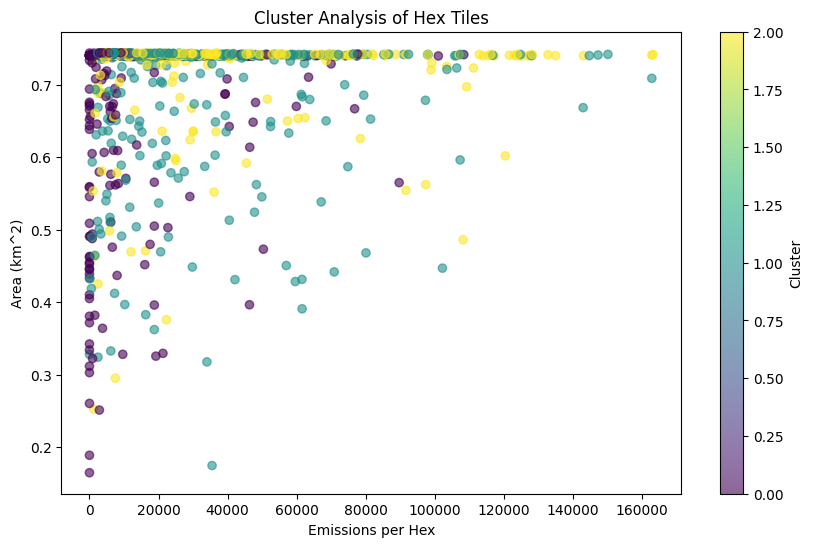

In [24]:
# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_reg)

# Plot clustering results
plt.figure(figsize=(10, 6))
plt.scatter(data['emissions_per_hex'], data['area_km2'], c=clusters, cmap='viridis', alpha=0.6)
plt.title('Cluster Analysis of Hex Tiles')
plt.xlabel('Emissions per Hex')
plt.ylabel('Area (km^2)')
plt.colorbar(label='Cluster')
plt.show()

In [25]:
# Feature Engineering
data['emissions_area_ratio'] = data['emissions_per_hex'] / data['area_km2']

# Regression Model
X_reg = data[['EV_Station_Count', 'area_km2', 'emissions_per_hex', 'emissions_area_ratio']]
y_reg = data['lst_value']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_reg, y_train_reg)
y_pred_reg = rf_regressor.predict(X_test_reg)
print("Regression MSE:", mean_squared_error(y_test_reg, y_pred_reg))

Regression MSE: 33.07288108737793


In [26]:
# Classification Model
X_class = data.drop(['has_green_space', 'lst_value'], axis=1)
y_class = data['has_green_space']
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_class, y_train_class)
y_pred_class = rf_classifier.predict(X_test_class)
print("Classification Report:\n", classification_report(y_test_class, y_pred_class))

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.71      0.72       126
           1       0.57      0.58      0.57        83

    accuracy                           0.66       209
   macro avg       0.65      0.65      0.65       209
weighted avg       0.66      0.66      0.66       209



## PCA

In [33]:
data = HEXS
if data['geometry'].dtype == 'object':
    data['geometry'] = gpd.GeoSeries.from_wkt(data['geometry'])
gdf = gpd.GeoDataFrame(data, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True) 

,hex_id,has_green_space,EV_Station_Count,area_km2,emissions_per_hex,EV_DEMAND_COUNT,mean_centrality,Mean_Degree,street_density_km,geometry,lst_value
0,882a106e0dfffff,1,0.0,0.548716,5059.507584,5.0,0.009831,5.204545,2.156995e+09,"POLYGON ((564391.40636 4483712.57130, 564550.8...",0.000000
1,882a106e63fffff,1,0.0,0.738377,15457.885399,17.0,0.009838,5.750000,2.356213e+09,"POLYGON ((564550.81068 4484208.00389, 564391.4...",20.925329
2,882a106e67fffff,1,0.0,0.324066,2462.177860,0.0,0.009593,5.214286,2.325496e+09,"POLYGON ((563637.57853 4484457.73880, 563478.1...",22.617778
3,882a106e47fffff,1,0.0,0.738411,6870.573109,0.0,0.010138,4.466667,1.058723e+09,"POLYGON ((566159.77079 4484576.58483, 566000.3...",20.245281
4,882a106e6bfffff,1,0.0,0.738450,15987.604986,38.0,0.010616,4.666667,2.343848e+09,"POLYGON ((565246.55391 4484826.32942, 565087.1...",20.925329
...,...,...,...,...,...,...,...,...,...,...,...
1040,882a100165fffff,1,0.0,0.743671,9121.595692,0.0,0.012448,2.950000,8.951534e+08,"POLYGON ((594534.81916 4527880.65859, 594374.2...",18.342644
1041,882a100a59fffff,1,0.0,0.743711,7131.953484,3.0,0.013728,4.851852,1.341215e+09,"POLYGON ((593619.94607 4528131.73359, 593459.3...",18.651034
1042,882a10016dfffff,1,0.0,0.729818,758.259344,2.0,0.012181,4.000000,7.395428e+08,"POLYGON ((595233.12837 4528501.93806, 595072.5...",18.823216
1043,882a1018b3fffff,1,0.0,0.743783,5661.403695,0.0,0.009419,2.666667,5.041706e+08,"POLYGON ((594318.23828 4528753.03163, 594157.6...",18.651034


In [42]:
# Standardizing the data
numeric_data = data.select_dtypes(include=[np.number])
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_data)

In [50]:
# Performing PCA
pca = PCA()
principal_components = pca.fit_transform(numeric_data_scaled)
explained_variance_ratio = pca.explained_variance_ratio_ 
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

In [60]:
loadings = pca.components_.T  # Transpose to align with the desired output format

# Creating a DataFrame for the loadings
loadings_df = pd.DataFrame(data=loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=numeric_data.columns)

print("PCA Loadings:")
loadings_df

PCA Loadings:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
has_green_space,0.242239,-0.001300,-0.328952,0.868589,-0.066372,-0.196340,0.146853,0.042266,-0.111152
EV_Station_Count,-0.044968,0.507200,0.364927,0.145762,0.336537,-0.344922,-0.181161,0.477354,0.305604
area_km2,-0.460003,-0.077906,-0.246740,0.098586,0.557901,-0.248819,-0.278940,-0.508794,0.043403
emissions_per_hex,-0.233196,0.424087,-0.417200,0.078840,-0.295087,0.437102,-0.143535,-0.049655,0.533194
EV_DEMAND_COUNT,-0.409350,0.297703,0.288795,0.188476,0.189263,0.361333,0.618652,-0.108928,-0.252790
mean_centrality,-0.161136,0.377394,-0.429064,-0.347939,-0.229223,-0.556953,0.327385,0.050271,-0.232386
Mean_Degree,-0.343621,-0.363719,0.311653,0.125112,-0.392778,-0.361599,0.280716,-0.125004,0.507344
street_density_km,-0.528445,-0.033963,0.126952,0.178861,-0.394734,0.015718,-0.485322,0.241459,-0.470725
lst_value,-0.287146,-0.438553,-0.378074,-0.064358,0.292496,0.133233,0.207256,0.648605,0.105770


In [80]:
# Explained variance ratio and PCA components shape
variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Variance Explained': cumulative_variance
})

print("PCA Components Shape:", principal_components.shape)
print("\nExplained Variance Ratio:")
variance_df

PCA Components Shape: (1045, 9)

Explained Variance Ratio:


,Principal Component,Explained Variance Ratio,Cumulative Variance Explained
0,PC1,0.237294,0.237294
1,PC2,0.213356,0.450650
2,PC3,0.135297,0.585947
3,PC4,0.102573,0.688521
4,PC5,0.096218,0.784738
5,PC6,0.077674,0.862412
6,PC7,0.054580,0.916992
7,PC8,0.043621,0.960613
8,PC9,0.039387,1.000000


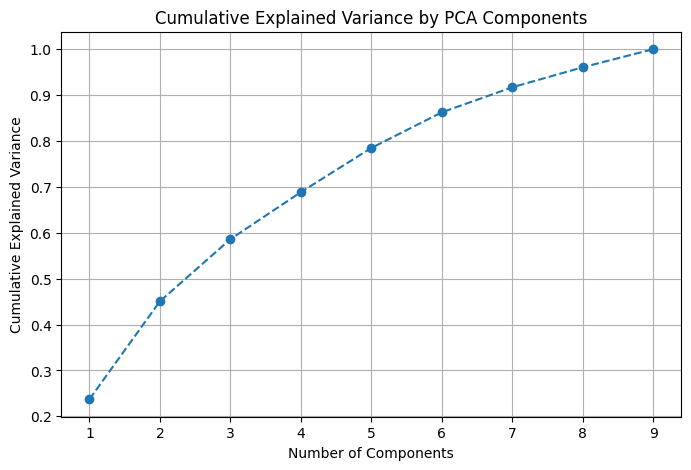

(1045, 8)

In [53]:
# Plotting the cumulative variance explained by the principal components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [44]:
# Creating a DataFrame for PCA components
pca_df = pd.DataFrame(data=principal_components, columns=[f'Principal Component {i+1}' for i in range(principal_components.shape[1])])
pca_df['hex_id'] = data['hex_id']  # include hex_id for reference
pca_df

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6,Principal Component 7,Principal Component 8,Principal Component 9,hex_id
0,2.587062,-0.338642,2.130077,1.672470,-1.468339,0.412733,-1.079413,-1.130531,-0.188656,882a106e0dfffff
1,0.159131,-1.815771,0.675383,1.903858,0.189980,0.427946,-0.671953,-0.207361,0.522875,882a106e63fffff
2,2.711029,-1.786104,1.488794,1.254120,-1.855300,1.398559,0.041895,2.320310,0.010465,882a106e67fffff
3,1.808689,-1.434280,-0.079059,1.258451,1.270829,0.496866,-0.731042,-0.343161,0.405808,882a106e47fffff
4,0.211065,-0.955703,0.343223,1.768579,0.769203,0.995092,-0.403400,-0.121543,-0.408338,882a106e6bfffff
...,...,...,...,...,...,...,...,...,...,...
1040,2.391329,-0.207602,-1.070151,0.651260,1.730119,0.525524,-0.878649,-0.323494,-0.662903,882a100165fffff
1041,1.202790,-0.836860,-0.512508,0.829915,0.558273,-0.602746,-0.198972,-0.434326,0.048527,882a100a59fffff
1042,2.155715,-0.823197,-0.497401,0.793289,1.376700,0.088448,-0.338047,-0.402876,-0.087218,882a10016dfffff
1043,2.984836,-0.677515,-0.589134,1.012712,2.413133,1.387237,-1.198070,-0.424621,-0.353422,882a1018b3fffff


## K-means Clustering

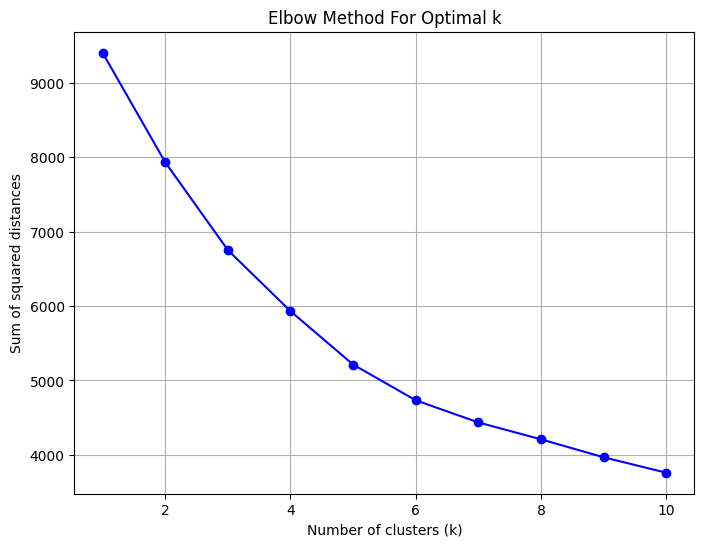

In [55]:
# Determine the optimal number of clusters using the Elbow Method
k_range = range(1, 11)
ssd = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(principal_components)
    ssd.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, ssd, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

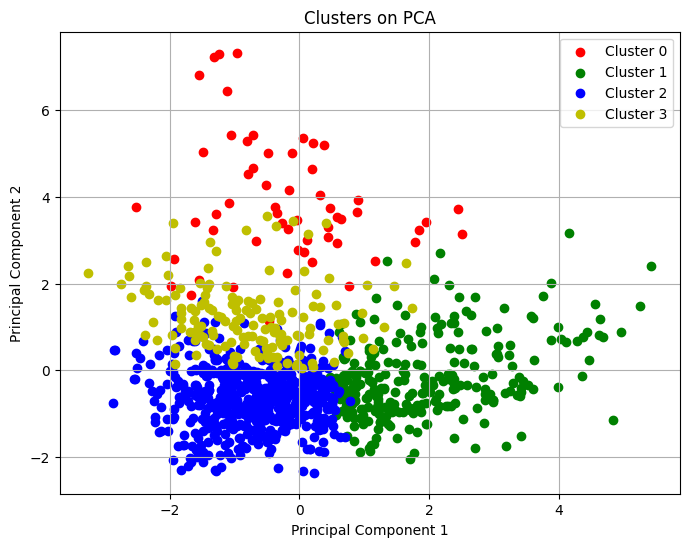

In [56]:
# Choose k based on the plot and apply K-means clustering
k = 4  # This value might change based on your plot observation
kmeans = KMeans(n_clusters=k, random_state=0)
pca_df['Cluster'] = kmeans.fit_predict(principal_components)

# Plotting the clusters on the PCA plot
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'y']
for i in range(k):
    plt.scatter(pca_df[pca_df['Cluster'] == i]['Principal Component 1'], pca_df[pca_df['Cluster'] == i]['Principal Component 2'], color=colors[i], label=f'Cluster {i}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters on PCA')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
# Filter the PCA DataFrame to include only numeric columns before aggregation
numeric_pca_df = pca_df.select_dtypes(include=[np.number])

# Check if the Cluster column exists and apply K-means clustering if not already done
kmeans = KMeans(n_clusters=4, random_state=0)  # Adjust k based on your earlier analysis
cluster_labels = kmeans.fit_predict(principal_components)
numeric_pca_df['Cluster'] = cluster_labels

cluster_characteristics = numeric_pca_df.groupby('Cluster').mean()
cluster_std = numeric_pca_df.groupby('Cluster').std()

print("Cluster Characteristics (Mean values):")
print(cluster_characteristics)

print("\nCluster Characteristics (Standard Deviations):")
print(cluster_std)

Cluster Characteristics (Mean values):
         Principal Component 1  Principal Component 2  Principal Component 3  \
Cluster                                                                        
0                    -0.222902               3.862108               1.802395   
1                     1.921387              -0.197425              -0.070321   
2                    -0.703102              -0.640517               0.260475   
3                    -0.778357               1.226686              -1.466753   

         Principal Component 4  Principal Component 5  Principal Component 6  \
Cluster                                                                        
0                     0.411435               0.824432              -0.758003   
1                    -0.006286               0.116132               0.078469   
2                    -0.019152               0.020521              -0.077017   
3                    -0.070787              -0.578612               0.414625   


## HEX Cluster

In [72]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import h3

In [63]:
# Assuming pca_df is the DataFrame containing the hex_id and Cluster columns
cluster_assignments = pca_df[['hex_id', 'Cluster']]

# Display the cluster assignments
print("Cluster Assignments for each hex_id:")
cluster_assignments.sort_values(by='Cluster')  # Optional sorting to group by cluster

Cluster Assignments for each hex_id:


,hex_id,Cluster
816,882a100e07fffff,0
450,882a100d67fffff,0
449,882a100d63fffff,0
447,882a107253fffff,0
446,882a100d2dfffff,0
...,...,...
853,882a100c01fffff,3
854,882a100c05fffff,3
855,882a100c09fffff,3
430,882a100d19fffff,3


In [71]:
# Merging the geometry information back into the pca_df
HEX_Cluster = pca_df.merge(data[['hex_id', 'geometry']], on='hex_id', how='left')[['hex_id', 'Cluster', 'geometry']]
HEX_Cluster

,hex_id,Cluster,geometry
0,882a106e0dfffff,1,"POLYGON ((564391.4063561409 4483712.571295817,..."
1,882a106e63fffff,2,POLYGON ((564550.8106774171 4484208.0038944995...
2,882a106e67fffff,1,"POLYGON ((563637.5785253054 4484457.738802825,..."
3,882a106e47fffff,1,"POLYGON ((566159.770793673 4484576.584834952, ..."
4,882a106e6bfffff,2,POLYGON ((565246.5539134067 4484826.3294211915...
...,...,...,...
1040,882a100165fffff,1,"POLYGON ((594534.8191603607 4527880.658590008,..."
1041,882a100a59fffff,1,"POLYGON ((593619.9460665126 4528131.73359345, ..."
1042,882a10016dfffff,1,"POLYGON ((595233.128365306 4528501.938056614, ..."
1043,882a1018b3fffff,1,"POLYGON ((594318.2382842175 4528753.031633702,..."


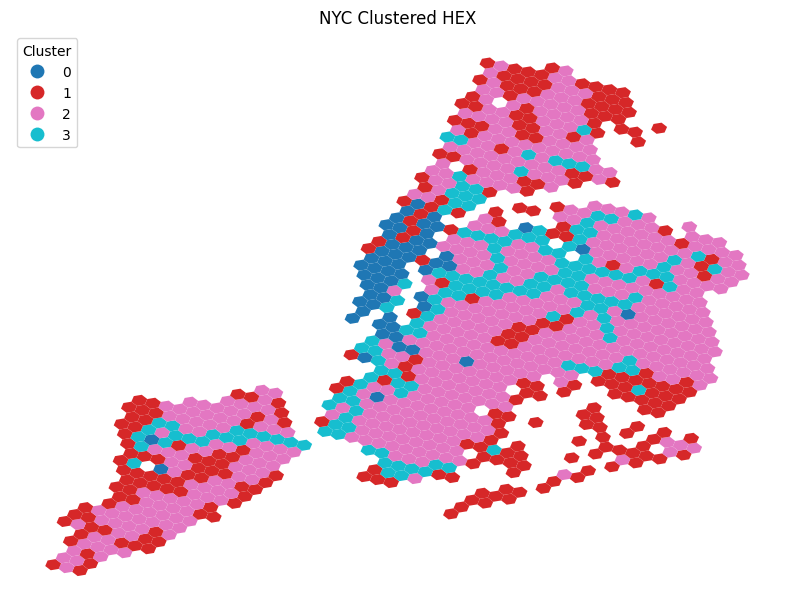

In [75]:
# Converting H3 hex IDs to polygon geometries
def hex_to_polygon(hex_id):
    # Convert the hex id to a polygon boundary (assuming geo_json=True for alignment)
    boundary = h3.h3_to_geo_boundary(hex_id, geo_json=True)
    return Polygon(boundary)

# Assuming 'HEX_Cluster' is your DataFrame and needs conversion
HEX_Cluster['geometry'] = HEX_Cluster['hex_id'].apply(hex_to_polygon)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(HEX_Cluster, geometry='geometry')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='Cluster', ax=ax, categorical=True, legend=True, legend_kwds={'title': 'Cluster', 'loc': 'upper left'})
plt.title('NYC Clustered HEX')
ax.set_axis_off()  # This line removes the axes
plt.show()